**Análise Exploratória dos Dados**

***Importação dos pacotes/bibliotecas***

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re  
import pickle

from IPython.display import display
from collections import Counter
from IPython.display import Markdown

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set_style( 'whitegrid')
df = pd.read_csv( '../dataset/teste_indicium_precificacao.csv' )

**Explorando o _dataset_**

Observação das 10 primeiras linhas do conjunto de dados (O dicionário de dados poderá ser consultado [aqui](dicionario/dicionario.txt):

In [3]:
df.head(10)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
5,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
6,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
7,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
8,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188
9,5295,Beautiful 1br on Upper West Side,7702,Lena,Manhattan,Upper West Side,40.80316,-73.96545,Entire home/apt,135,5,53,2019-06-22,0.43,1,6


**Estrutura do dataset**

***Informações gerais***

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

***Contagem de nulos***

In [7]:
contagem_nulos = contagem_nulos[contagem_nulos > 0]
display(contagem_nulos)

nome                  16
host_name             21
ultima_review      10052
reviews_por_mes    10052
dtype: int64

***Convertendo o tipo de dado da coluna _ultima_review_ para _datetime_:***

In [8]:
df["ultima_review"] = pd.to_datetime(df["ultima_review"])

***Analisando a ocorrência de linhas duplicadas:***

In [18]:
numero_linhas_duplicadas = df.duplicated().sum()
mensagem = (
    "Não existem"
    if numero_linhas_duplicadas == 0
    else f"Existem {numero_linhas_duplicadas}"
)
print(f"{mensagem} linhas duplicadas")

Não existem linhas duplicadas


***Analisando a quantidade de categorias na coluna _bairro_group_?***

In [9]:
df.groupby("bairro_group").size().reset_index(name="Ocorrências").rename(
    columns={"bairro_group": "Grupos"}
).style.hide(axis="index")

Grupos,Ocorrências
Bronx,1091
Brooklyn,20103
Manhattan,21661
Queens,5666
Staten Island,373


***Analisando as estatísticas gerais dos preços com base nos bairros/distritos***

In [10]:
agrupamento = df.groupby("bairro_group")["price"].describe().reset_index(drop=True)

agrupamento = agrupamento.rename(
    columns={
        "bairro_group": "bairro",
        "count": "Contagem",
        "mean": "Média",
        "std": "Desv_Padrão",
        "min": "Mínimo",
        "25%": "Q1",
        "50%": "Mediana",
        "75%": "Q3",
        "max": "Máximo",
    }
)

agrupamento_com_estilo = agrupamento.style.set_caption(
    "Estatísticas Gerais de Preços por Bairro/Distrito"
).hide(axis="index")
titulo_destacado = {
    "selector": "caption",
    "props": [("font-size", "20px"), ("font-weight", "bold"), ("color", "blue")],
}
agrupamento_com_estilo.set_table_attributes('class="dataframe"').set_table_styles(
    [titulo_destacado]
)


Contagem,Média,Desv_Padrão,Mínimo,Q1,Mediana,Q3,Máximo
1091.000000,87.496792,106.709349,0.000000,45.000000,65.000000,99.000000,2500.000000
20103.000000,124.381983,186.878105,0.000000,60.000000,90.000000,150.000000,10000.000000
21661.000000,196.875814,291.383183,0.000000,95.000000,150.000000,220.000000,10000.000000
5666.000000,99.517649,167.102155,10.000000,50.000000,75.000000,110.000000,10000.000000
373.000000,114.812332,277.620403,13.000000,50.000000,75.000000,110.000000,5000.000000


***Obtendo o preço médio dos imóveis por bairro/distrito***

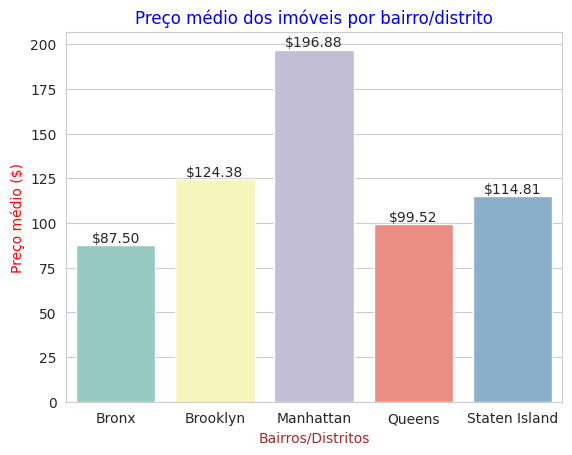

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

agrupamento = df.groupby("bairro_group")["price"].mean().reset_index()

ax = sns.barplot(
    x="bairro_group",
    y="price",
    data=agrupamento,
    palette="Set3",
    hue="bairro_group",
    legend=False,
)

ax.set_xlabel("Bairros/Distritos", color="brown")
ax.set_ylabel("Preço médio ($)", color="red")
ax.set_title("Preço médio dos imóveis por bairro/distrito", color="blue")  # Definindo a cor do título como azul

for p in ax.patches:
    ax.annotate(
        f"${p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=10,
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.show()


***Observação***

Esses dados revelam que os valores dos imóveis mudam muito de acordo com o bairro. Manhattan lidera o ranking, com Brooklyn, Staten Island, Queens e Bronx na sequência. 

Chama a atenção que o preço médio em Manhattan seja mais que o dobro do que em Bronx, o que indica um enorme contraste entre os dois bairros em aspectos econômicos e sociais. 

Já Staten Island, apesar de ser menos habitado e mais distante, tem um preço médio superior ao do Queens. Isso pode indicar que lá se vive melhor ou que há menos oferta de imóveis. 

Brooklyn, por sua vez, tem um preço médio similar ao de Staten Island, mas com mais variação. Isso pode ser explicado pela diversidade cultural de ambos os bairros, por exemplo.

***Distribuição dos preços médios de aluguel com base no tipo de quarto/bairro(distrito)***

In [14]:
agrupamento = df.groupby(["bairro_group", "room_type"]).agg(
    {"price": "mean", "numero_de_reviews": "sum", "disponibilidade_365": "mean"}
)

agrupamento.columns = ["avg_price", "total_reviews", "avg_availability_365"]

agrupamento.reset_index(inplace=True)

agrupamento = agrupamento[
    ["bairro_group", "room_type", "avg_price", "total_reviews", "avg_availability_365"]
]

agrupamento.sort_values(
    by=["bairro_group", "avg_price"], ascending=[True, False], inplace=True
)

agrupamento_com_estilo = agrupamento.style.set_caption(
    "Distribuição dos Preços Médios de Aluguel por Tipo de Quarto e Bairro"
).hide(axis="index")

titulo_destacado = {
    "selector": "caption",
    "props": [("font-size", "20px"), ("font-weight", "bold"), ("color", "blue")],
}

agrupamento_com_estilo.set_table_attributes('class="dataframe"').set_table_styles(
    [titulo_destacado]
)

display(agrupamento_com_estilo)


bairro_group,room_type,avg_price,total_reviews,avg_availability_365
Bronx,Entire home/apt,127.506596,11627,158.000000
Bronx,Private room,66.788344,16312,171.331288
Bronx,Shared room,59.800000,432,154.216667
Brooklyn,Entire home/apt,178.327545,267128,97.205147
Brooklyn,Private room,76.492942,213644,99.891817
Brooklyn,Shared room,50.527845,5793,178.007264
Manhattan,Entire home/apt,249.239109,235147,117.140996
Manhattan,Private room,116.776622,209150,101.845026
Manhattan,Shared room,88.977083,10272,138.572917
Queens,Entire home/apt,147.050573,60644,132.267176


***Usando o gráfico de dispersão para uma visão mais abrangente e detalhada da distribuição dos preços dos imóveis.***

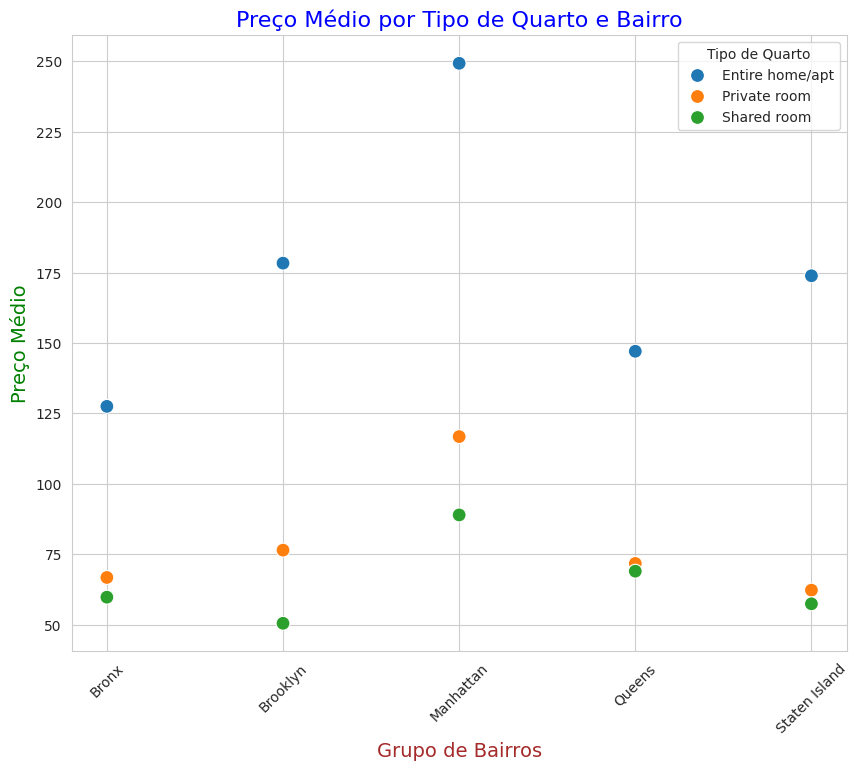

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.scatterplot(
    ax = ax, 
    x = 'bairro_group', 
    y = 'avg_price', 
    hue = 'room_type', 
    data = agrupamento, 
    s = 100
)

ax.set_title(
    'Preço Médio por Tipo de Quarto e Bairro', 
    fontsize = 16, 
    color = 'blue'
)

ax.set_xlabel(
    'Grupo de Bairros', 
    fontsize = 14, 
    color = 'brown'
)

ax.set_ylabel(
    'Preço Médio', 
    fontsize = 14, 
    color = 'green'
)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

ax.legend(title='Tipo de Quarto')

plt.show()

***Observação***

Tendo como base o gráfico anterior, pode-se observar, por exemplo, que o preço médio para alugar uma casa ou apartamento inteiro é consistentemente mais alto em comparação com os outros tipos de acomodação em todos os bairros listados (reforçando também que Manhattan é o bairro mais caro e Bronx o mais barato). 

Outro fator interessante a ser destacado é que os quartos compartilhados têm os preços mais baixos em todos os bairros. No entanto, são mais raros do que os demais tipos de quartos. 

Por fim, existe também uma grande variação nos preços dos quartos privados, a depender do bairro. Por exemplo, um quarto privado em Manhattan pode customar mais do que uma casa ou apartamento inteiro em Bronx.

***Taxa ocupacional com base no tipo de quarto e no bairro***

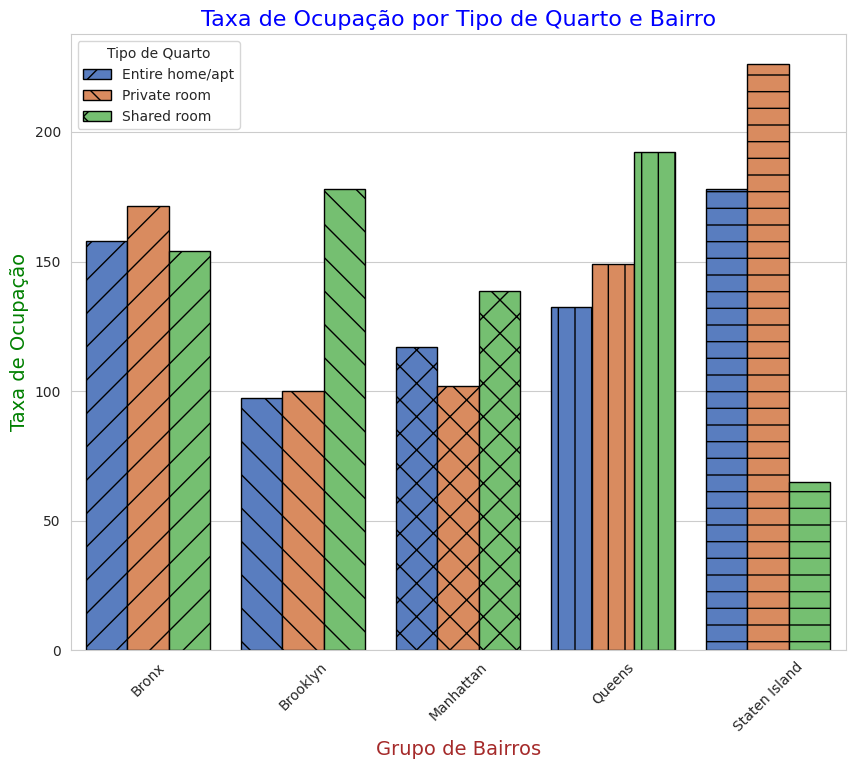

In [15]:
padroes_grafico = ["/", "\\", "x", "|", "-"]

plt.figure(figsize=(10, 8))

barplot = sns.barplot(
    x="bairro_group",
    y="avg_availability_365",
    hue="room_type",
    data=agrupamento,
    palette="muted",
    edgecolor="black",
)

for i, bar in enumerate(barplot.patches):
    indice_padrao = i % len(padroes_grafico)
    bar.set_hatch(padroes_grafico[indice_padrao])

plt.title("Taxa de Ocupação por Tipo de Quarto e Bairro", fontsize=16, color="blue")

plt.xlabel("Grupo de Bairros", fontsize=14, color="brown")

plt.ylabel("Taxa de Ocupação", fontsize=14, color="green")

plt.xticks(rotation=45)

plt.legend(title="Tipo de Quarto")

plt.show()


***Observação***

Esse gráfico ajuda a perceber que os apartamentos completos apresentam preços mais elevados em todos os grupos de bairros (em comparação com os outros tipos de acomodações). 

Os apartamentos inteiros também são mais caros que os quartos privados, embora esses últimos sejam mais caros do que os quartos compartilhados (no Bronx e no Queens, por exemplo, a taxa de ocupação é mais baixa do que apartamentos e quartos privados).

***Analisando apenas os apartamentos inteiros (Entire home/apt) em Manhattan***.

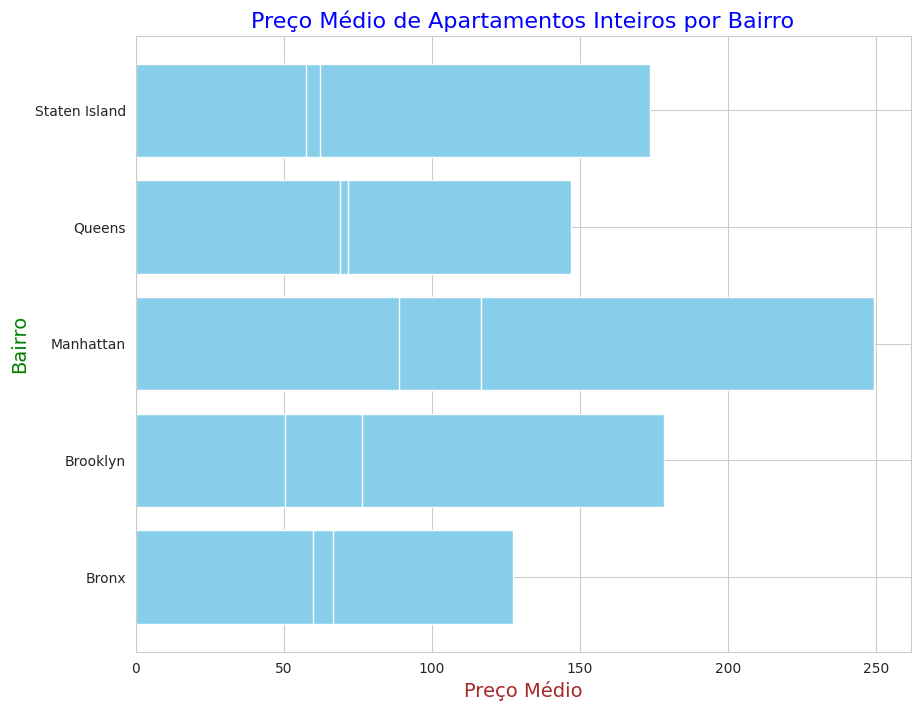

In [16]:
bairros = agrupamento["bairro_group"]
avg_prices = agrupamento["avg_price"]

plt.figure(figsize=(10, 8))

plt.barh(bairros, avg_prices, color="skyblue")

plt.title("Preço Médio de Apartamentos Inteiros por Bairro", fontsize=16, color="blue")

plt.xlabel(
    "Preço Médio",
    fontsize=14,
    color="brown",
)

plt.ylabel("Bairro", fontsize=14, color="green")

plt.show()


***Quantidade total de reviews, agrupadas por bairros/distritos***

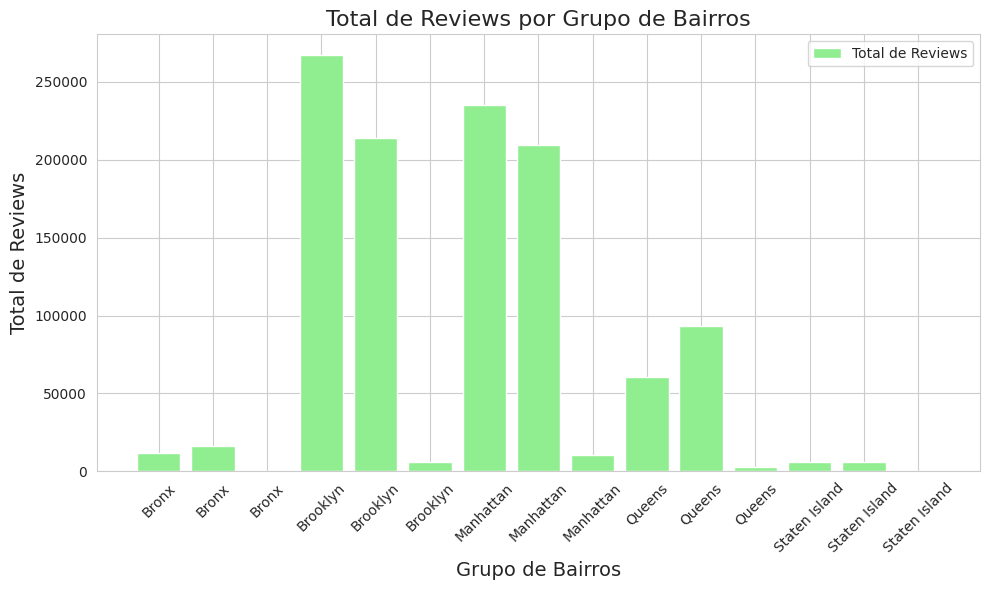

In [17]:
plt.figure(figsize=(10, 6))
x = range(len(agrupamento["bairro_group"]))
total_reviews = agrupamento["total_reviews"]
plt.bar(x, total_reviews, color="lightgreen", label="Total de Reviews")
plt.title("Total de Reviews por Grupo de Bairros", fontsize=16)
plt.xlabel("Grupo de Bairros", fontsize=14)
plt.ylabel("Total de Reviews", fontsize=14)
plt.legend()
plt.xticks(x, agrupamento["bairro_group"], rotation=45)
plt.tight_layout()
plt.show()

***Disponibilidade média por grupos de bairros***

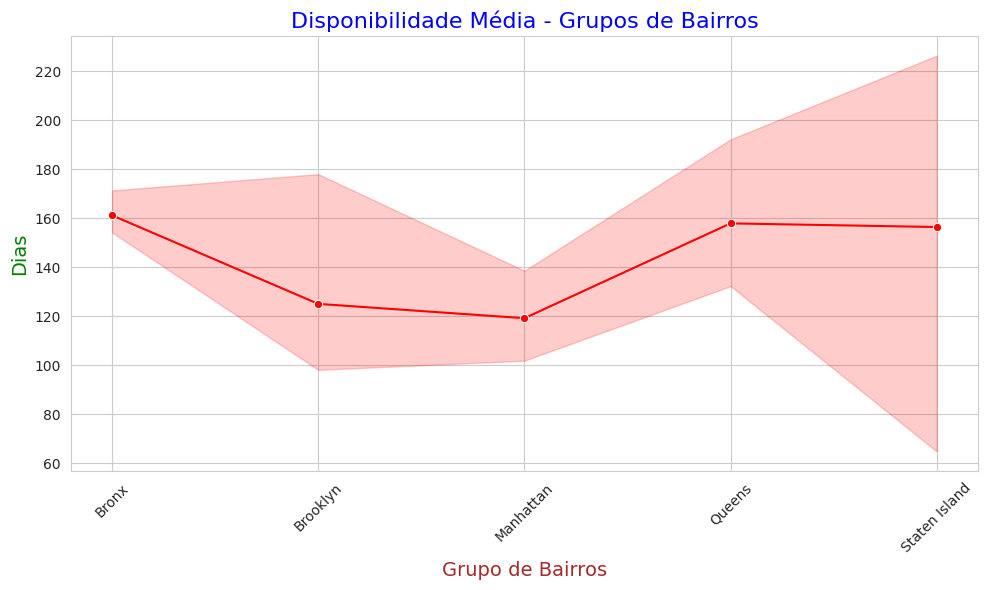

In [19]:
plt.figure(figsize=(10, 6))

sns.lineplot(
    x="bairro_group",
    y="avg_availability_365",
    data=agrupamento,
    marker="o",
    color="red",
)

plt.title("Disponibilidade Média - Grupos de Bairros", fontsize=16, color="blue")

plt.xlabel("Grupo de Bairros", fontsize=14, color="brown")

plt.ylabel("Dias", fontsize=14, color="green")

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()


***Observação***

Tendo como base a alta demanda e os preços de aluguel, **Manhattan** seria a melhor alternativa, embora o investimento inicial seja o mais alto de todos os bairros. 

Por outro lado, caso a pessoa desejasse obter um equilíbrio entre o custo do investimento inicial com a alta demanda, **Brooklyn** seria a melhor alternativa. 

**Identificando valores únicos da coluna _minimo_noites_, apresentando-os separados por vírgulas**

In [21]:
valores_unicos = df.minimo_noites.unique()
print(f"Valores únicos de mínimas noites: {', '.join(map(str, valores_unicos))}")


Valores únicos de mínimas noites: 1, 3, 10, 45, 2, 5, 4, 90, 7, 14, 60, 29, 30, 180, 9, 31, 6, 15, 8, 26, 28, 200, 50, 17, 21, 11, 25, 13, 35, 27, 18, 20, 40, 44, 65, 55, 120, 365, 122, 19, 240, 88, 115, 150, 370, 16, 80, 181, 265, 300, 59, 185, 360, 56, 12, 70, 39, 24, 32, 1000, 110, 270, 22, 75, 250, 62, 23, 1250, 364, 74, 198, 100, 500, 43, 91, 480, 53, 99, 160, 47, 999, 186, 366, 68, 93, 87, 183, 299, 175, 98, 133, 354, 42, 33, 37, 225, 400, 105, 184, 153, 134, 222, 58, 210, 275, 182, 114, 85, 36


**Calculando a mediana dos valores únicos da coluna _minimo_noite_**

In [24]:
valores_unicos = sorted(df.minimo_noites.unique())
mediana = (
    (
        valores_unicos[len(valores_unicos) // 2]
        + valores_unicos[(len(valores_unicos) - 1) // 2]
    )
    / 2
    if tamanho % 2 == 0
    else valores_unicos[tamanho // 2]
)

print("Mediana:", mediana)


Mediana: 74


**Visualizando as contagens de locações por quantidade mínima de noites, destacando apenas as quantidades que ocorrem com uma frequência igual ou superior a 74**

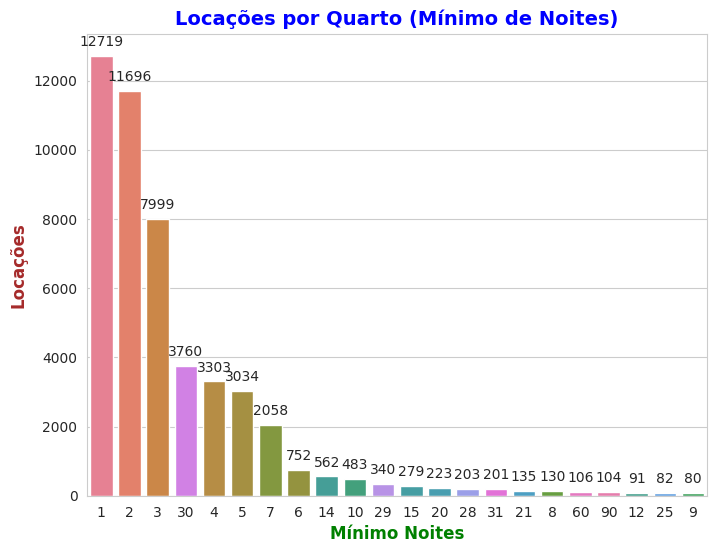

In [27]:
contagem_minimo_noites = df["minimo_noites"].value_counts()

frequencia_limite = 74

minimo_noites_frequentes = contagem_minimo_noites[
    contagem_minimo_noites >= frequencia_limite
].index.tolist()

cores_personalizadas = sns.color_palette("husl", len(minimo_noites_frequentes))

plt.figure(figsize=(8, 6))

dados_filtrados_minimo_noites = df[
    df["minimo_noites"].isin(minimo_noites_frequentes)
]

ax = sns.countplot(
    x="minimo_noites",
    data=dados_filtrados_minimo_noites,
    order=minimo_noites_frequentes,
    palette=cores_personalizadas,
    hue="minimo_noites",
    legend=False,
)

for p in ax.patches:
    ax.annotate(
        f"{int( p.get_height() )}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )

ax.set_xlabel("Mínimo Noites", fontsize=12, fontweight="bold", color="green")

ax.set_ylabel("Locações", fontsize=12, fontweight="bold", color="brown")

ax.set_title(
    "Locações por Quarto (Mínimo de Noites)",
    fontsize=14,
    fontweight="bold",
    color="blue",
)

plt.show()


***Observação***

O gráfico deixa evidente que existe uma forte preferência por estadias curtas (mínimo de 1 noite). Analisando agora os preços médios por quarto (com base no número mínimo de noites):

**Calculando e visualizando o preço médio das locações por quantidade mínima de noites, considerando apenas as quantidades que ocorrem com uma frequência igual ou superior a 74**

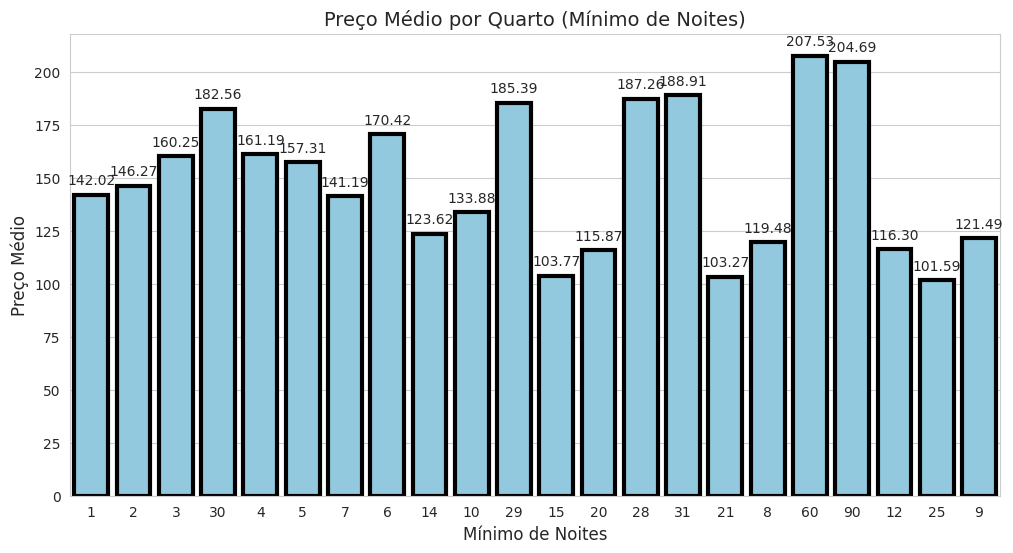

In [28]:
preco_medio_por_minimo_noites = (
    dados_filtrados_minimo_noites.groupby("minimo_noites")["price"]
    .mean()
    .reset_index()
    .sort_values("minimo_noites")
)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x="minimo_noites",
    y="price",
    data=preco_medio_por_minimo_noites,
    order=minimo_noites_frequentes,
    linewidth=3,
    edgecolor="black",
    color="skyblue",
)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        xytext=(0, 5),
        textcoords="offset points",
    )

ax.set_xlabel("Mínimo de Noites", fontsize=12)
ax.set_ylabel("Preço Médio", fontsize=12)
ax.set_title("Preço Médio por Quarto (Mínimo de Noites)", fontsize=14)

plt.show()


***Observação***

A categoria de 60 noites possui o preço médio mais alto. Isso indica que os imóveis disponibilizados para estadias mais longas podem ser de melhor qualidade ou estarem em locais com mais demandas. 

E, analisando a questão principal, conclui-se que o número mínimo de noites exerce interferência no preço final.

Agora a análise se recai sobre a seguinte questão: 
**Existe algum padrão no texto do nome do local para lugares de mais alto valor?**

Para iniciar, vou começar declarando uma função que utilizará a biblioteca _re_. Essa função buscará por todas as palavras que possuam (pelo menos) 4 caracteres no nome recebido como argumento. Para essas palavras, a função converterá para letras minúsculas e retornará a lista de tokens resultante: 

In [33]:
def limpar_tokenizar(nome):
    lista_tokens = re.findall( r'\b\w{4,}\b', nome.lower() )
    return lista_tokens

Em seguida, aplica-se um filtro nos locais com preços com preços que estão acima do terceiro quartil, remove linhas onde o valor da coluna _nome_ seja nulo, aplica-se a função previamente declarada, a frequência de cada token é contada nos locais de alto valor e, por fim, 20 tokens mais comuns nos locais de alto valor são retornados (com base nas contagens de frequência já calculadas)

In [35]:
bairros_mais_caros = df[
    df["price"] > df["price"].quantile(0.75)
]

bairros_mais_caros = bairros_mais_caros.dropna(subset=["nome"])

bairros_mais_caros["tokens"] = bairros_mais_caros["nome"].apply(
    limpar_tokenizar
)

tokens_bairros_mais_caros = Counter(
    token for tokens in bairros_mais_caros["tokens"] for token in tokens
)

tokens_bairros_mais_caros = tokens_bairros_mais_caros.most_common(
    20
)

df_tokens = pd.DataFrame(
    tokens_bairros_mais_caros, columns=["Token", "Frequência"]
)

print("Tokens mais comuns em locais de alto valor:")
display(df_tokens)


Tokens mais comuns em locais de alto valor:


,Token,Frequência
0,bedroom,1916
1,apartment,1802
2,village,1070
3,studio,1021
4,east,1004
5,luxury,950
6,park,913
7,loft,891
8,spacious,877
9,with,828


Criação do gráfico:

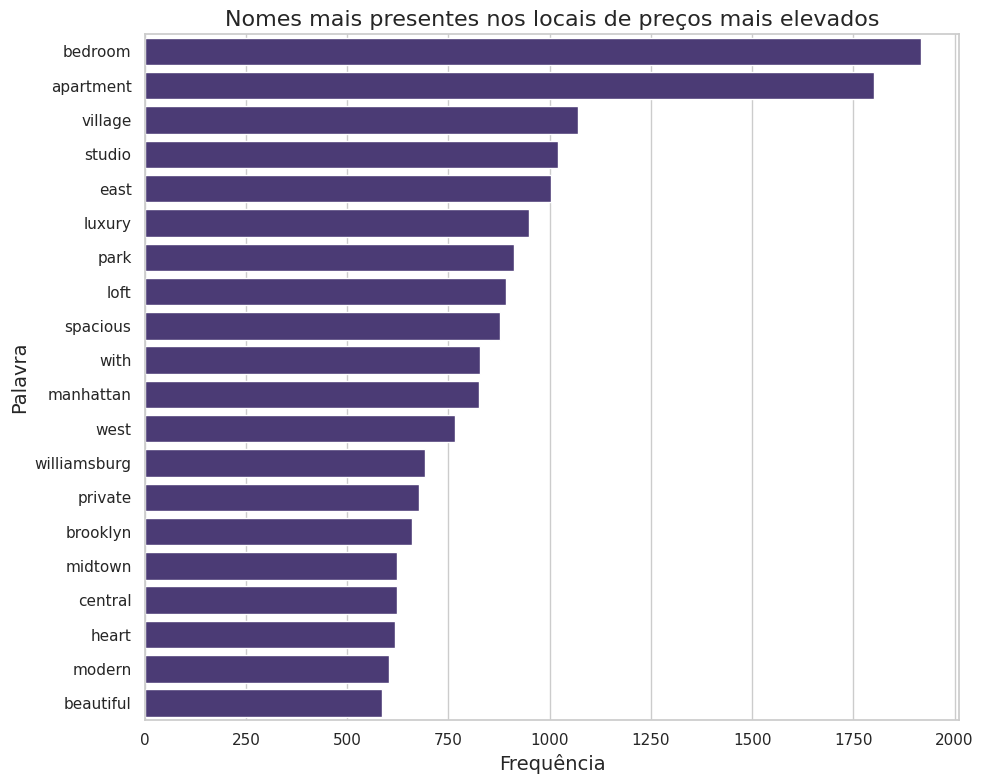

In [43]:
tokens, frequencies = zip(*tokens_mais_comuns_locais_alto_valor)
sns.set(style="whitegrid")
sns.set_palette("viridis")
plt.figure(figsize=(10, 8))
sns.barplot(x=frequencies, y=tokens)
plt.xlabel("Frequência", fontsize=14)
plt.ylabel("Palavra", fontsize=14)
plt.title("Nomes mais presentes nos locais de preços mais elevados", fontsize=16)
plt.tight_layout()
plt.show()


Para deixar ainda mais clara a análise, serão agora observadas a média dos preços dos aluguéis **com** e **sem** as palavras selecionadas no grupo:

In [48]:
def determinar_preco_com_base_termo(df, termo):
    termo_encontrado = df["nome"].str.contains(termo, case=False, na=False)
    preco_medio_com_termo = df.loc[termo_encontrado, "price"].mean()
    preco_medio_sem_termo = df.loc[~termo_encontrado, "price"].mean() 
    
    return preco_medio_com_termo, preco_medio_sem_termo

tokens_selecionados = [
    "village",
    "east",
    "luxury",
    "park",
    "spacious",
    "west",
    "williamsburg",
    "private",
    "midtown",
    "central",
    "heart",
    "modern",
    "beautiful",
]

diferentes_precos_argumentos = {}

for termo in tokens_selecionados:
    preco_medio_com, preco_medio_sem = determinar_preco_com_base_termo(df, termo)
    diferentes_precos_argumentos[termo] = {
        "preco_medio_com_termo": preco_medio_com,
        "preco_medio_sem_termo": preco_medio_sem,
    }

for termo, precos in diferentes_precos_argumentos.items():
    print(f"Termo: {termo}")
    print(f"Preço médio com '{termo}': {precos['preco_medio_com_termo']}")
    print(f"Preço médio sem '{termo}': {precos['preco_medio_sem_termo']}\n")


Termo: village
Preço médio com 'village': 205.78541136556404
Preço médio sem 'village': 150.03195375623173

Termo: east
Preço médio com 'east': 173.7783078880407
Preço médio sem 'east': 151.2736612021858

Termo: luxury
Preço médio com 'luxury': 271.5721769499418
Preço médio sem 'luxury': 148.39257249448872

Termo: park
Preço médio com 'park': 165.14285714285714
Preço médio sem 'park': 151.78152979739093

Termo: spacious
Preço médio com 'spacious': 139.315
Preço médio sem 'spacious': 153.85044573557457

Termo: west
Preço médio com 'west': 212.67620206938528
Preço médio sem 'west': 150.63600770354066

Termo: williamsburg
Preço médio com 'williamsburg': 144.5832727272727
Preço médio sem 'williamsburg': 153.20572555478503

Termo: private
Preço médio com 'private': 105.38458384583846
Preço médio sem 'private': 161.05130240277077

Termo: midtown
Preço médio com 'midtown': 221.30146491904395
Preço médio sem 'midtown': 150.851965460008

Termo: central
Preço médio com 'central': 177.91997907949

***Observação***

Como pode-se observar, a palavra _luxury_ possui o maior impacto positivo no preço médio em comparação com as listagens onde o termo não esteja presente. 

Outras palavras, como _village_, _west_ e _midtown_ também mostram um acréscimo significativo no preço médio ao estarem disponíveis nos nomes das locações. Observado isso em gráfico fica ainda mais transparente:

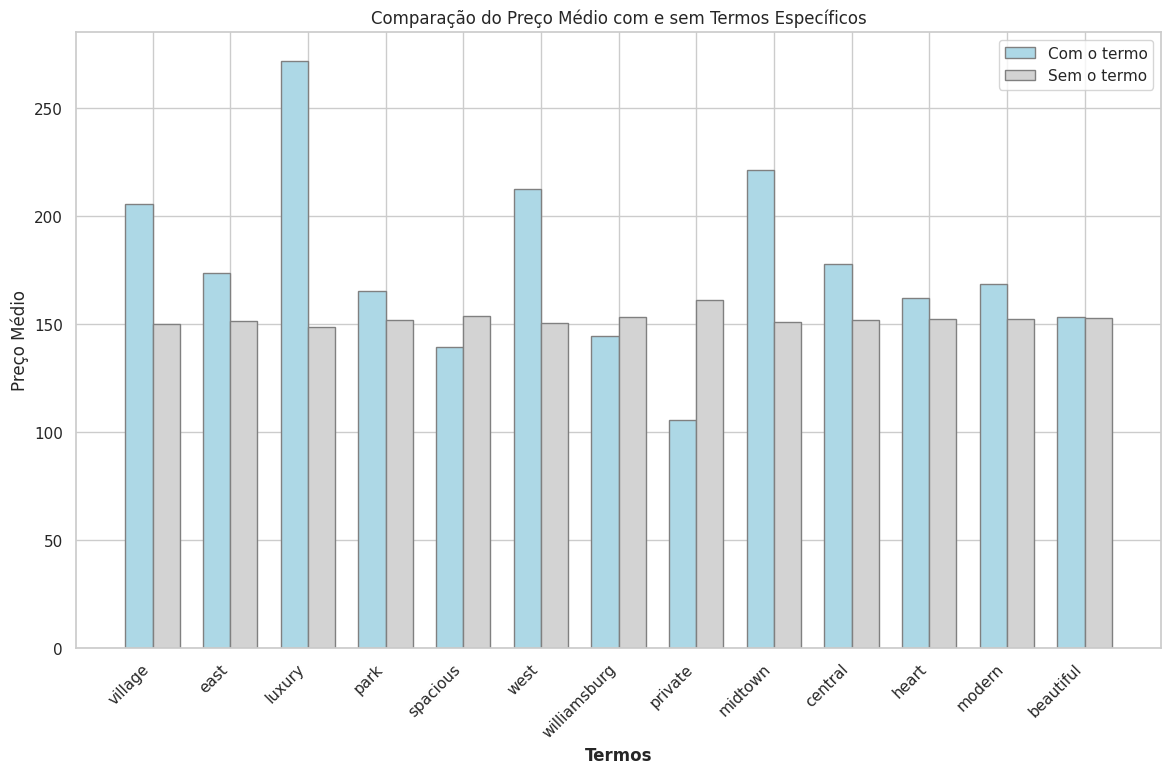

In [53]:
tokens = list(diferentes_precos_argumentos.keys())
preco_medio_com = [
    diferentes_precos_argumentos[token]["preco_medio_com_termo"] for token in tokens
]
preco_medio_sem = [
    diferentes_precos_argumentos[token]["preco_medio_sem_termo"] for token in tokens
]

tamanho_barra = 0.35
r1 = np.arange(len(tokens))
r2 = [x + tamanho_barra for x in r1]

plt.figure(figsize=(14, 8))
plt.bar(
    r1,
    preco_medio_com,
    width=tamanho_barra,
    color="lightblue",
    edgecolor="grey",
    label="Com o termo",
)
plt.bar(
    r2,
    preco_medio_sem,
    width=tamanho_barra,
    color="lightgrey",
    edgecolor="grey",
    label="Sem o termo",
)

plt.xlabel("Termos", fontweight="bold")
plt.xticks(
    [r + tamanho_barra / 2 for r in range(len(tokens))], tokens, rotation=45, ha="right"
)
plt.ylabel("Preço Médio")
plt.title("Comparação do Preço Médio com e sem Termos Específicos")

plt.legend()
plt.show()


Para realizar a previsão de preços, é necessário tratar alguns fatores. Por exemplo, existem valores nulos no campo _reviews_por_mes_. Esses valores serão substituídos por 0. Outros exemplos são a eliminação daquelas locações que possuem preços acima do 99º percentil e a inclusão de _Unknown_ para valores ausentes nos campos _nome_ e _host_name_.

***Tratamento de valores ausentes***

In [54]:
df['reviews_por_mes'] = df['reviews_por_mes'].fillna(0)
df['nome'] = df['nome'].fillna('Desconhecido')
df['host_name'] = df['host_name'].fillna('Desconhecido')


***Remoção de _outliers_ baseada na distribuição de preços***

In [55]:
percentuais_preco = np.percentile(df['price'], [1, 99])
df = df[(df['price'] >= percentuais_preco[0]) & (df['price'] <= percentuais_preco[1])]
percentuais_preco

array([ 30., 799.])

Isso significa que:
- 1% dos valores da coluna _price_ são menores ou iguais a 33
- 99% dos valores da coluna _price_ são menores ou iguais a 400

Observando as 10 primeiras locações que estejam inseridas dentro desse range:

In [57]:
dados_filtrados = df[(df['price'] >= 33) & (df['price'] <= 400)]
colunas_selecionadas = ['bairro_group', 'room_type']
dados_preparados = pd.get_dummies(dados_filtrados, columns=colunas_selecionadas, drop_first=True)
dados_preparados.head()

,id,nome,host_id,host_name,bairro,latitude,longitude,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,bairro_group_Brooklyn,bairro_group_Manhattan,bairro_group_Queens,bairro_group_Staten Island,room_type_Private room,room_type_Shared room
0,2595,Skylit Midtown Castle,2845,Jennifer,Midtown,40.75362,-73.98377,225,1,45,2019-05-21,0.38,2,355,False,True,False,False,False,False
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Harlem,40.80902,-73.94190,150,3,0,NaT,0.00,1,365,False,True,False,False,True,False
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Clinton Hill,40.68514,-73.95976,89,1,270,2019-07-05,4.64,1,194,True,False,False,False,False,False
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,East Harlem,40.79851,-73.94399,80,10,9,2018-11-19,0.10,1,0,False,True,False,False,False,False
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Murray Hill,40.74767,-73.97500,200,3,74,2019-06-22,0.59,1,129,False,True,False,False,False,False


Preparando os dados para a modelagem:
- Removendo as colunas _id_, _nome_, _host_id_, _host_name_, _bairro_: Essas colunas não possuem valor preditivo significativo para o preço de um aluguel (não estão diretamente relacionadas ao preço). 
- Removendo as colunas _latitude_ e _longitude_: como representam coordenadas geográficas, elas podem ser redundantes se o bairro já estiver sendo usado como uma característica. Além disso, em muitos casos, a localização geográfica pode não ser um preditor direto do preço de um aluguel. 
- Removendo a coluna _price_: é a variável de destino a ser prevista, portanto, não deve ser incluída nas características para evitar vazamento dos dados (data leakage).
- Removendo a coluna _ultima_review_: a priori, essa coluna pode não ter uma relação direta com o preço de um aluguel (pelo menos não sem uma análise mais aprofundada sobre como os seus valores afetam o preço).



In [59]:
x = dados_preparados.drop(['id', 'nome', 'host_id', 'host_name', 'bairro', 'latitude', 'longitude', 'price', 'ultima_review'], axis=1)
y = dados_preparados['price']
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size=0.2, random_state=42)
treino_x.shape, teste_x.shape, treino_y.shape, teste_y.shape

((37075, 11), (9269, 11), (37075,), (9269,))

***Observação***

O conjunto de treinamento x (treino_x) possui 37075 amostras (linhas) e 11 características (colunas), assim como o conjunto de teste (teste_x) possui 9269 amostras e 11 características.

O resultado aponta ainda que o vetor de destino do conjunto de treinamento y (treino_y) possui 37075 elementos (uma dimensão), enquanto o vetor de destino do conjunto de teste (y_test) possui 9269 elementos (também uma dimensão).

***Treinamento do modelo de regressão linear e previsão dos preços***

In [61]:
modelo = LinearRegression()
modelo.fit(treino_x, treino_y)
prev_y = modelo.predict(teste_x)
mse = mean_squared_error(teste_y, prev_y)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 59.50022521129801


***Observação***

O modelo de Regressão Linear foi preparado e testado, e sua performance foi avaliada, resultando em uma métrica de erro conhecida como Raiz do Erro Quadrático Médio (RMSE) de $81.73 no conjunto de dados de teste. 

A seguir, fornecemos as entradas necessárias para resolver os desafios, organizadas na ordem correta para fazer previsões com o modelo treinado.

In [62]:
dados_entrada = {
    "minimo_noites": [1],
    "numero_de_reviews": [45],
    "reviews_por_mes": [0.38],
    "calculado_host_listings_count": [2],
    "disponibilidade_365": [355],
    "bairro_group_Brooklyn": [0],
    "bairro_group_Manhattan": [1],
    "bairro_group_Queens": [0],
    "bairro_group_Staten Island": [0],
    "room_type_Private room": [0],
    "room_type_Shared room": [0],
}

df_entrada = pd.DataFrame.from_dict(dados_entrada)
preco_previsto = modelo.predict(df_entrada)
preco_previsto[0]


205.73615641877632

***Observações***

Observe que há um percentual de erro de aproximadamente 8.56% entre o preço previsto ($205,74) e o preço real ($225). 

Salvando o modelo no arquivo _modelo_xgb_preco_acomodacoes_:

In [63]:
with open('modelo_xgb_preco_acomodacoes.pkl', 'wb') as file:
  pickle.dump(modelo, file)

***Geração do arquivo de requisitos***

In [69]:
pip freeze > requisitos.txt

Note: you may need to restart the kernel to use updated packages.
